## Generate predictions
Loop over audio to generate predictions and create a DF with predicted and actual label

In [17]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

SC = {
    'AUDIO_CLIP_DURATION': 2,
    'AUDIO_NFFT': 2048,
    'AUDIO_WINDOW': None,
    'AUDIO_STRIDE': 200,
    'AUDIO_SAMPLE_RATE': 16000,
    'AUDIO_MELS': 260,
    'AUDIO_FMIN': 20,
    'AUDIO_FMAX': 13000,
    'AUDIO_TOP_DB': 80,
}

def load_and_pad_audio(file_path, duration=2, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr)
    required_samples = sr * duration
    if len(audio) < required_samples:
        audio = np.pad(audio, (0, required_samples - len(audio)), 'constant')
    else:
        audio = audio[:required_samples]
    return audio, sr

def prepare_audio(file_path):
    audio, sr = load_and_pad_audio(file_path, duration=SC['AUDIO_CLIP_DURATION'], sr=SC['AUDIO_SAMPLE_RATE'])
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr,
        n_fft=SC['AUDIO_NFFT'],
        hop_length=SC['AUDIO_STRIDE'],
        n_mels=SC['AUDIO_MELS'],
        fmin=SC['AUDIO_FMIN'],
        fmax=SC['AUDIO_FMAX']
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, top_db=SC['AUDIO_TOP_DB'])
    spectrogram_resized = tf.image.resize(log_mel_spectrogram[np.newaxis, :, :, np.newaxis], [260, 260])
    spectrogram_resized = np.repeat(spectrogram_resized, 3, axis=-1)
    return spectrogram_resized


# Set the directory path containing the audio files
directory_path = r"D:\Deakin\Project Echo\Weather_Sounds\Weather_Sounds"

# Load the trained model
model = load_model('WeatherAudioDetectionModel.h5')

# Create a label encoder
encoder = LabelEncoder()
encoder.fit(['Earthquake', 'Rain', 'Thunder', 'Tornado'])

# Initialize an empty list to store the predictions
predictions_list = []

label_paths = ["Earthquake","Rain","Thunder","Tornado"]

# Loop over the subdirectories in the main directory
# for subdir in os.listdir(directory_path):
for subdir in label_paths:
    subdir_path = os.path.join(directory_path, subdir)
    if os.path.isdir(subdir_path):
        # Loop over the files in each subdirectory
        for filename in os.listdir(subdir_path):
            if filename.endswith(".wav"):  # Adjust the file extension if needed
                file_path = os.path.join(subdir_path, filename)
                # print(file_path)
                # Prepare the audio spectrogram
                input_spectrogram = prepare_audio(file_path)
                
                # Make predictions
                predictions = model.predict(input_spectrogram)
                predicted_class = np.argmax(predictions, axis=1)
                
                if predicted_class.size == 1:
                    predicted_class = predicted_class.item()
                
                predicted_label = encoder.inverse_transform([predicted_class])
                
                max_probability = np.max(predictions)
                
                confidence_threshold = 0.7
                if max_probability > confidence_threshold:
                    confidence = "High"
                else:
                    confidence = "Low"
                
                # Append the predictions to the list
                predictions_list.append({
                    "File": filename,
                    "Actual-Label": subdir,
                    # "Predicted Class Index": predicted_class,
                    "Predicted-Label": predicted_label[0],
                    # "Class Probabilities": predictions.flatten(),
                    # "Highest Class Probability": max_probability,
                    # "Confidence": confidence
                })

# Create a DataFrame from the predictions list
predictions_df = pd.DataFrame(predictions_list)

# Print the DataFrame
print(predictions_df)

1/1 [==============================] - 0s 81ms/step
                                File Actual-Label Predicted-Label
0             region_0.100-0.450.wav   Earthquake      Earthquake
1             region_0.100-4.100.wav   Earthquake      Earthquake
2             region_0.150-4.150.wav   Earthquake      Earthquake
3             region_1.050-5.050.wav   Earthquake      Earthquake
4         region_100.150-104.150.wav   Earthquake      Earthquake
...                              ...          ...             ...
10732   region_9985.250-9986.700.wav      Tornado         Tornado
10733   region_9986.800-9990.800.wav      Tornado         Tornado
10734   region_9990.800-9994.800.wav      Tornado         Tornado
10735   region_9994.800-9998.800.wav      Tornado         Tornado
10736  region_9998.800-10002.800.wav      Tornado         Tornado

[10737 rows x 3 columns]


In [19]:
predictions_df.to_csv('predicted_results')

## Evaluate results
Once the predicted_df is populated on your desired test set run below to see evaluation of each label

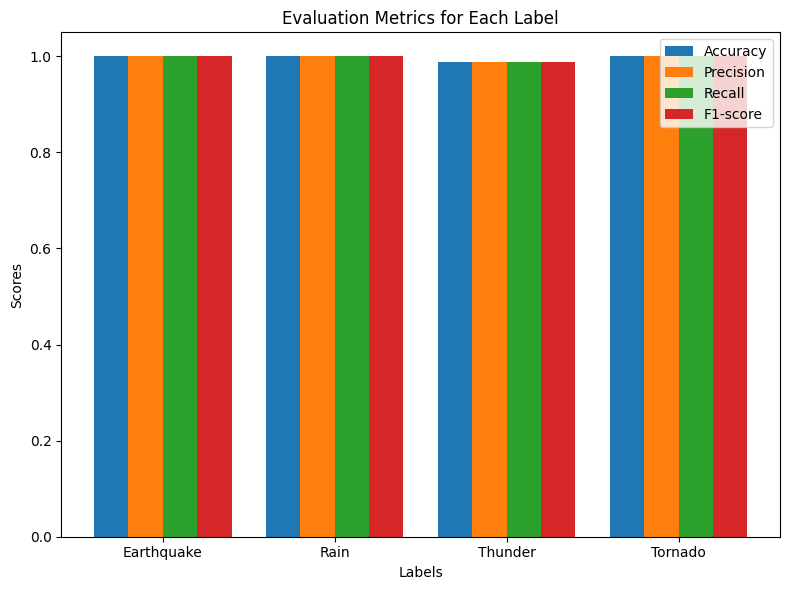

In [22]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'df'
# with columns 'filename', 'true_label', and 'predicted_label'

# Get the unique labels
labels = predictions_df['Actual-Label'].unique()

# Calculate evaluation metrics for each label
accuracies = []
precisions = []
recalls = []
f1_scores = []

for label in labels:
    true_labels = predictions_df[predictions_df['Actual-Label'] == label]['Actual-Label']
    predicted_labels = predictions_df[predictions_df['Actual-Label'] == label]['Predicted-Label']
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label=label, average='micro')
    recall = recall_score(true_labels, predicted_labels, pos_label=label, average='micro')
    f1 = f1_score(true_labels, predicted_labels, pos_label=label, average='micro')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Create a bar graph to visualize the accuracy for each label
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(labels))
width = 0.2

ax.bar(x, accuracies, width, label='Accuracy')
ax.bar([i + width for i in x], precisions, width, label='Precision')
ax.bar([i + 2 * width for i in x], recalls, width, label='Recall')
ax.bar([i + 3 * width for i in x], f1_scores, width, label='F1-score')

ax.set_xlabel('Labels')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Each Label')
ax.set_xticks([i + 1.5 * width for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

## Confusion matrix

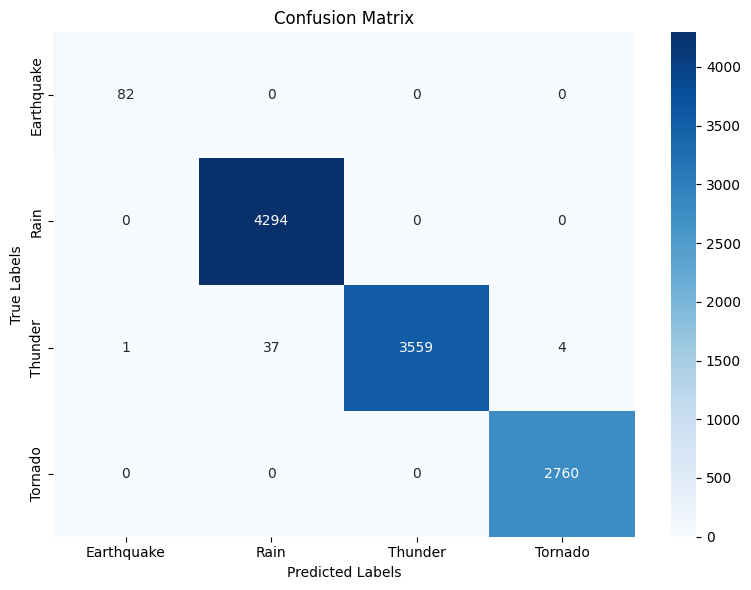

In [23]:
import seaborn as sns


cm = confusion_matrix(predictions_df['Actual-Label'], predictions_df['Predicted-Label'], labels=labels)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

d:\miniconda3\envs\project-echoTF\lib\site-packages\sklearn\metrics\_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
d:\miniconda3\envs\project-echoTF\lib\site-packages\sklearn\metrics\_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
d:\miniconda3\envs\project-echoTF\lib\site-packages\sklearn\metrics\_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
d:\miniconda3\envs\project-echoTF\lib\site-packages\sklearn\metrics\_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


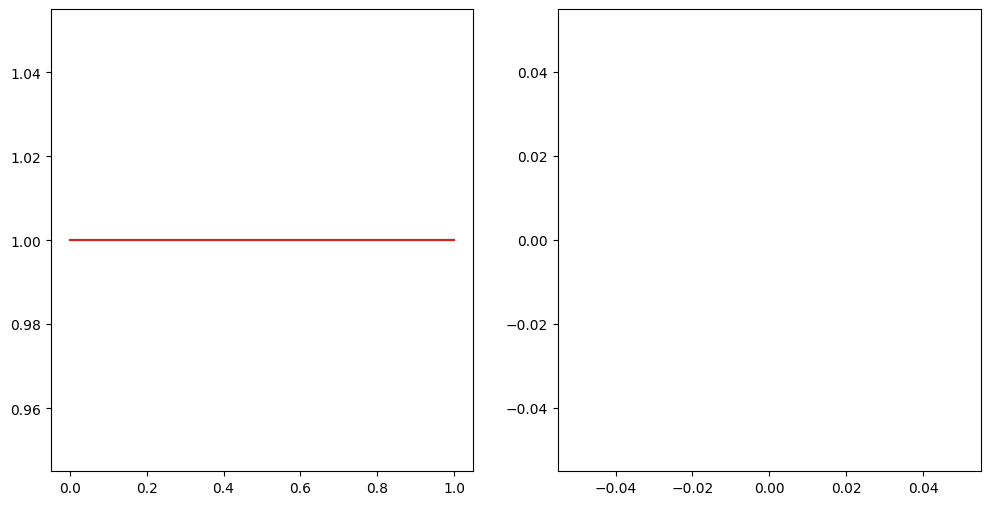

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, roc_curve, auc


# Assuming your data is stored in a DataFrame called 'df'
# with columns 'filename', 'true_label', and 'predicted_label'

# Get the unique labels
labels = predictions_df['Actual-Label'].unique()

# Create a label encoder
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# Create subplots for Precision-Recall curve and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Iterate over each label
for label in labels:
    true_labels = label_encoder.transform(predictions_df[predictions_df['Actual-Label'] == label]['Actual-Label'])
    predicted_labels = label_encoder.transform(predictions_df[predictions_df['Actual-Label'] == label]['Predicted-Label'])
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels, predicted_labels, pos_label=label_encoder.transform([label])[0])
    ax1.plot(recall, precision, label=label)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels, pos_label=label_encoder.transform([label])[0])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# ... (rest of the code remains the same)